### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [30]:
import json
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [3]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

with open("../dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)


In [4]:
with open("../dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

,src_port,dst_port,packet_size,duration_ms,protocol
0,80,9986,722,444,UDP
1,443,23013,1183,443,TCP
2,8080,38917,667,434,TCP
3,22,63696,1120,191,TCP
4,22,29642,1189,67,UDP
...,...,...,...,...,...
995,80,55447,827,237,TCP
996,22,61501,1169,364,TCP
997,22,17848,758,436,TCP
998,80,12324,1233,267,TCP


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [5]:
def preprocess_data(df):
    # Identify and convert batch columns to one-hot encoding
    df = pd.get_dummies(df, columns=['protocol'], drop_first=True)
    return df.astype(int).to_numpy()
normalized_df = preprocess_data(df)
display(normalized_df)

array([[   80,  9986,   722,   444,     1],
       [  443, 23013,  1183,   443,     0],
       [ 8080, 38917,   667,   434,     0],
       ...,
       [   22, 17848,   758,   436,     0],
       [   80, 12324,  1233,   267,     0],
       [ 8080, 63569,   806,   124,     0]], shape=(1000, 5))

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [6]:
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(normalized_df)

,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [7]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

# predict data

In [26]:
y_pred = model.predict(normalized_df)

Calculate decision scores and fit MinMaxScaler

In [12]:
decision_scores = model.decision_function(normalized_df)

In [15]:
scaler = MinMaxScaler()
scaler.fit(decision_scores.reshape(-1, 1))

,feature_range,"(0, ...)"
,copy,True
,clip,False


Save Scaler

In [16]:
joblib.dump(scaler, "confidence_scaler.joblib")

['confidence_scaler.joblib']

# 📊 Visualizing Anomalies and Normal Points using PCA

Scale the data to have zero mean and unit variance

In [31]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(normalized_df)

Reduce dimensionality using PCA

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)

Create DataFrame for plotting

In [33]:
plot_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
plot_df["Anomaly"] = y_pred

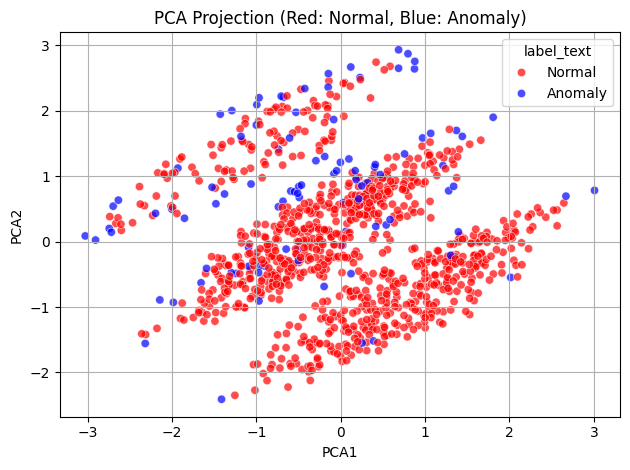

In [50]:
label_map = {1: "Normal", -1: "Anomaly"}
plot_df["label_text"] = plot_df["Anomaly"].map(label_map)

sns.scatterplot(
    data=plot_df,
    x="PCA1", y="PCA2",
    hue="label_text",
    palette={"Normal": "red", "Anomaly": "blue"},
    alpha=0.7
)
plt.title("PCA Projection (Red: Normal, Blue: Anomaly)")
plt.grid(True)
plt.tight_layout()
plt.show()